In [14]:
import warnings
#from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [88]:
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from scipy import stats
import statsmodels.api as sm


"""
from PIL import Image
from IPython.display import display


import matplotlib.ticker as ticker
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from lofo import LOFOImportance, Dataset, plot_importance
"""
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [16]:
file_path = "rnv_data.xlsx"
sheet_name='Ecommerce Customers'
df = pd.read_excel(file_path, sheet_name=sheet_name)
df_raw = df.copy()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB


In [18]:
df['Avatar'].nunique()

138

In [19]:
df.tail(4)

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
496,katrina56@gmail.com,"172 Owen Divide Suite 497\nWest Richard, CA 19320",PaleVioletRed,34.703,11.696,37.190,3.577,529.049
497,dale88@hotmail.com,"0787 Andrews Ranch Apt. 633\nSouth Chadburgh, ...",Cornsilk,32.647,11.499,38.333,4.958,551.620
498,cwilson@hotmail.com,"680 Jennifer Lodge Apt. 808\nBrendachester, TX...",Teal,33.323,12.391,36.840,2.336,456.470
499,hannahwilson@davidson.com,49791 Rachel Heights Apt. 898\nEast Drewboroug...,DarkMagenta,33.716,12.419,35.771,2.735,497.779


In [20]:
num_cols = ['Avg. Session Length', 'Time on App', 'Time on Website','Length of Membership', 'Yearly Amount Spent']
cat_cols = ['Email','Address','Avatar']

Avg. Session Length


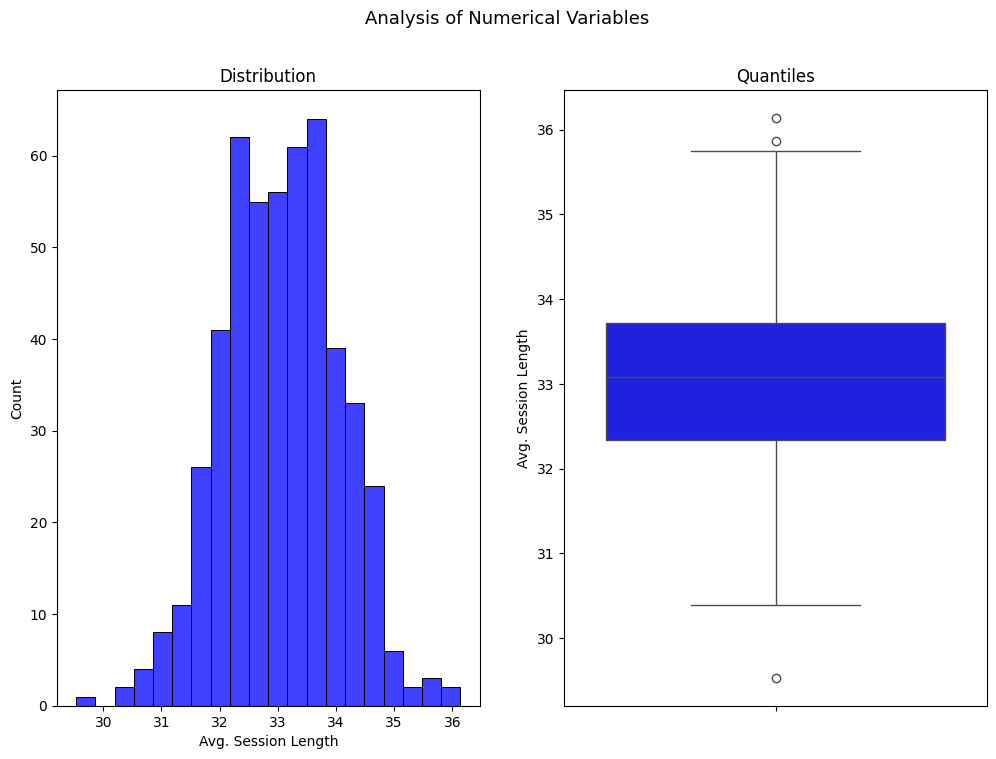

Time on App


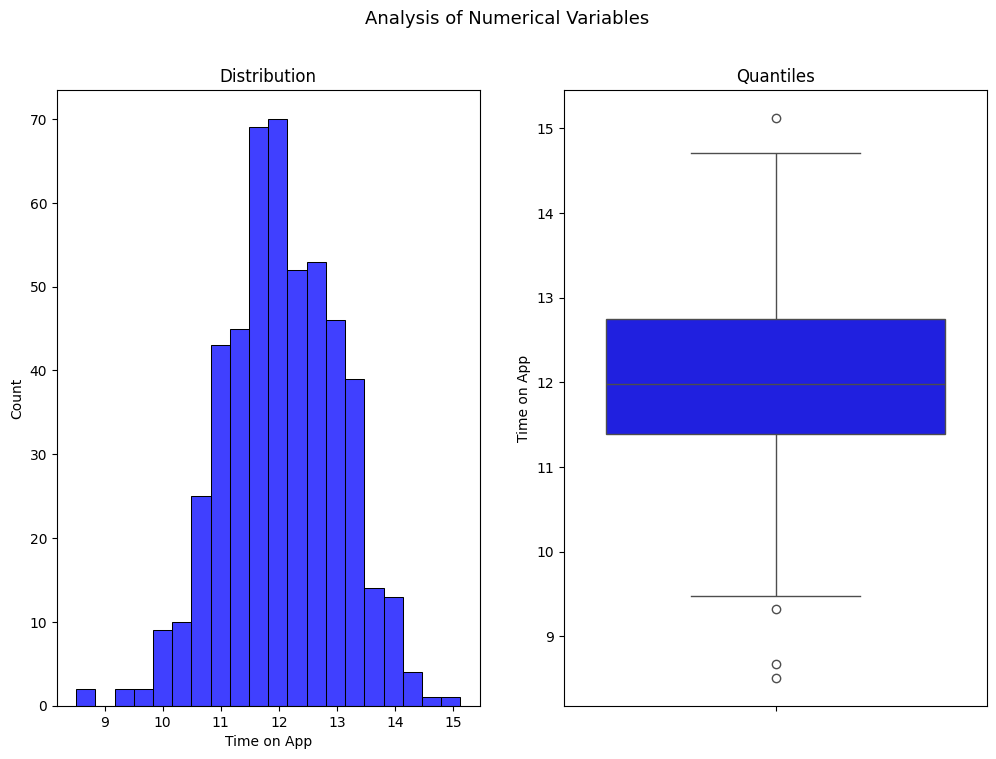

Time on Website


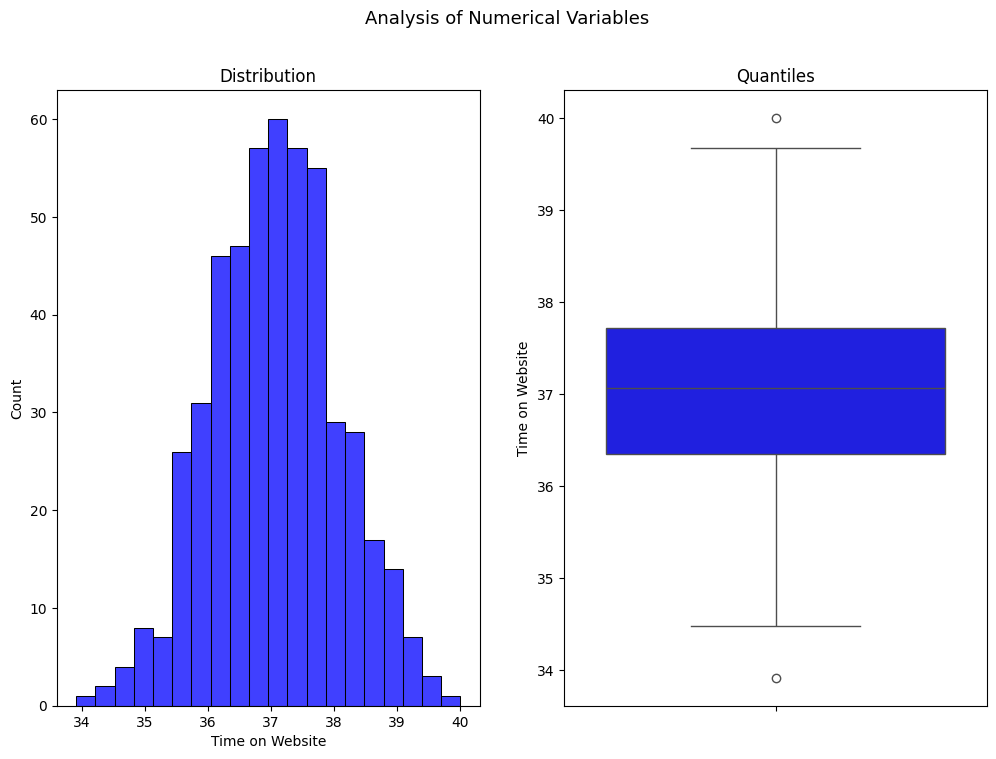

Length of Membership


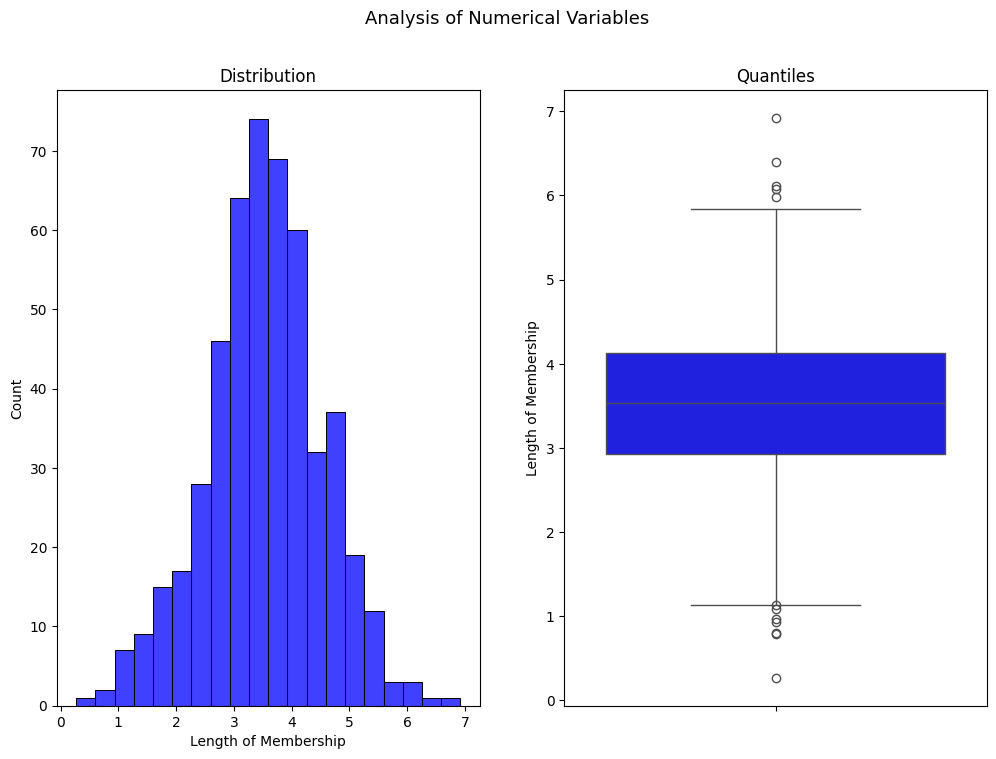

Yearly Amount Spent


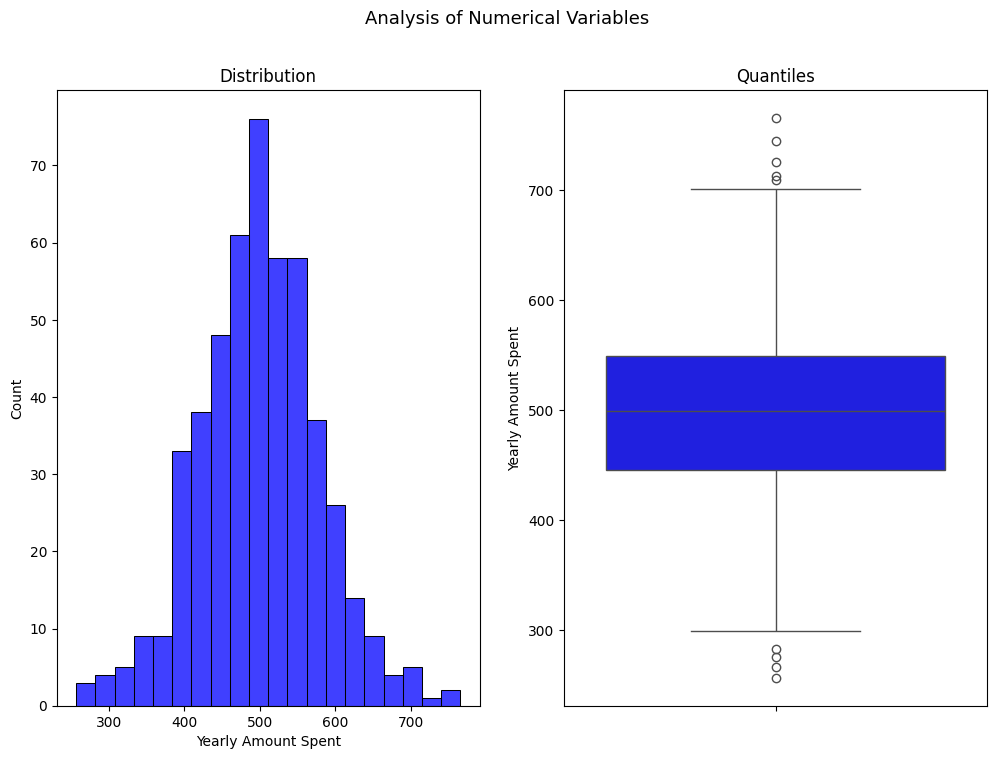

In [21]:
def num_summary(dataframe, numerical_col):
    # setup the plot grid
    fig, ax = plt.subplots(1, 2)
    ax = np.reshape(ax, (1, 2))
    ax[0, 0] = sns.histplot(x=dataframe[numerical_col], color="blue", bins=20, ax=ax[0, 0])
    ax[0, 0].set_ylabel('Count')
    ax[0, 0].set_title('Distribution')
    ax[0, 1] = sns.boxplot(y=dataframe[numerical_col], color="blue", ax=ax[0, 1])
    ax[0, 1].set_title('Quantiles')

    fig.set_size_inches(12, 8)
    fig.suptitle('Analysis of Numerical Variables', fontsize=13)
    plt.show()
    
for col in num_cols:
    print(col)
    num_summary(df, col)

In [68]:
df[num_cols].head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,34.497,12.656,39.578,4.083,587.951
1,31.926,11.109,37.269,2.664,392.205
2,33.001,11.330,37.111,4.105,487.548
3,34.306,13.718,36.721,3.120,581.852
4,33.331,12.795,37.537,4.446,599.406


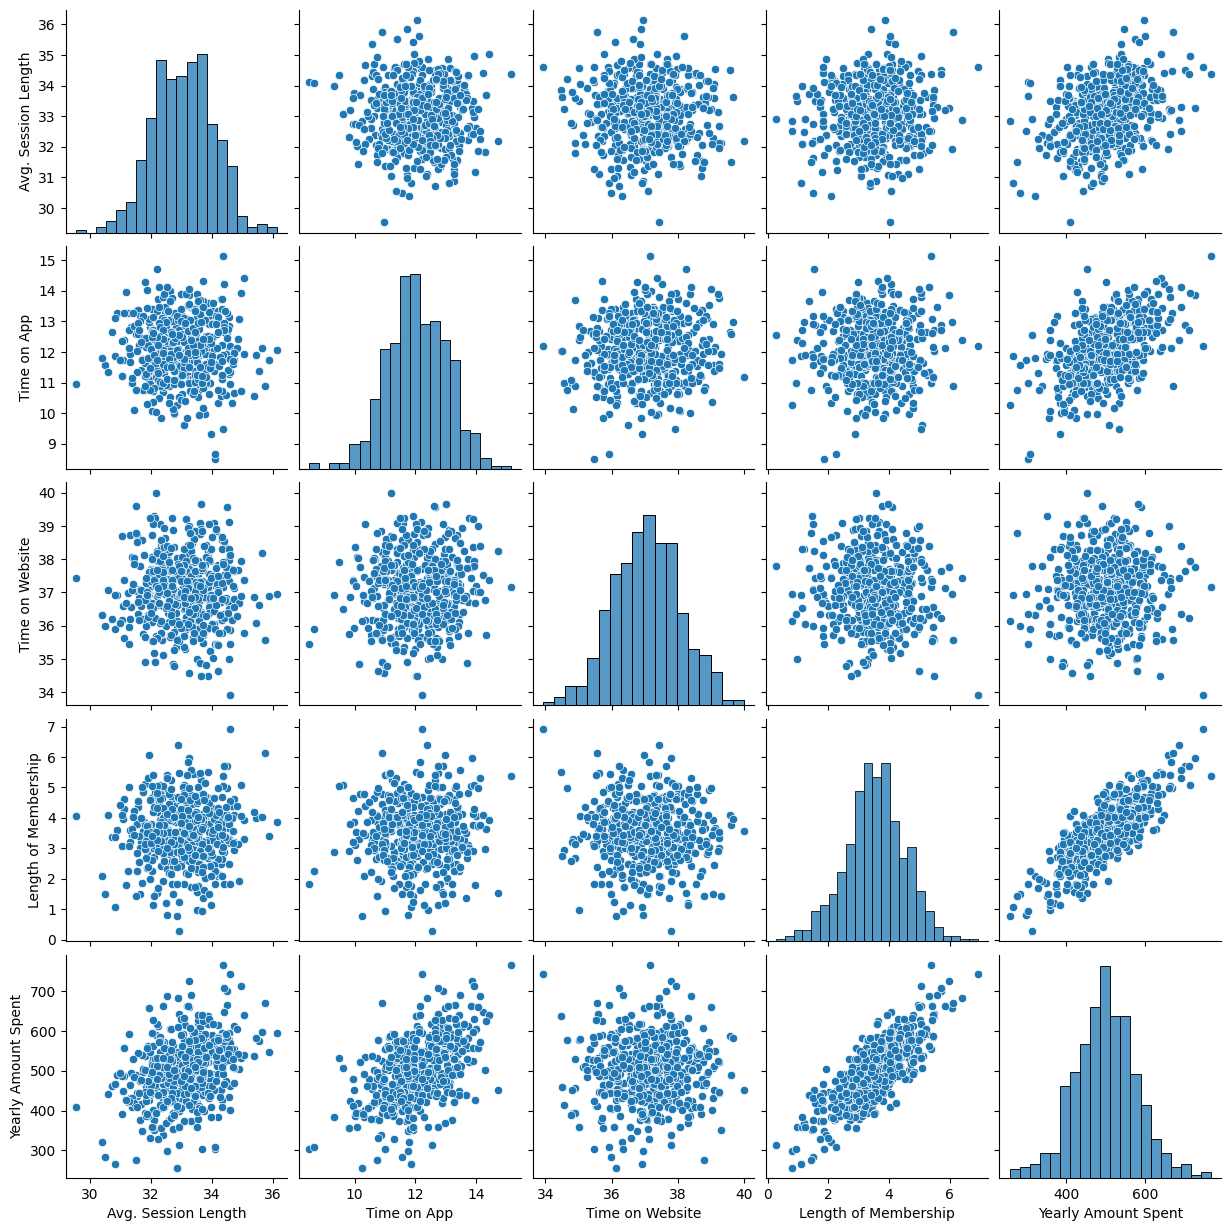

In [35]:
sns.pairplot(df[num_cols])

<Axes: >

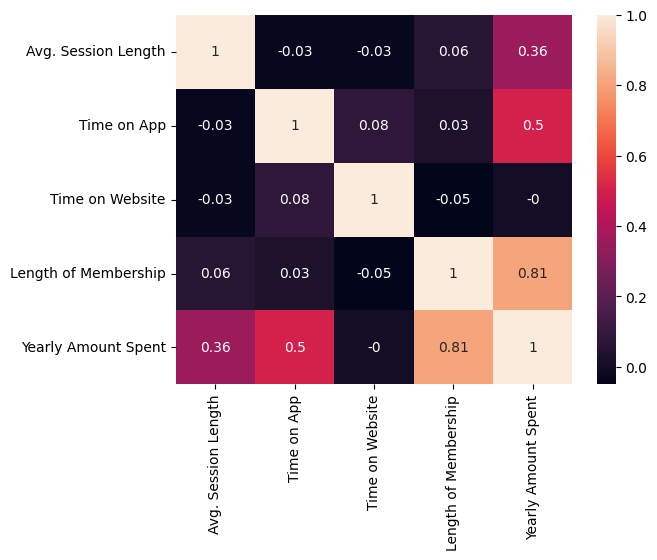

In [36]:
correlation_matrix = df[num_cols].corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [49]:
# Statistical tests: Shapiro-Wilk test for normality
print("Shapiro-Wilk Test:")
for column in df[num_cols].columns:
    _, p = stats.shapiro(df[column])
    print(f"{column}: p = {p}")

Shapiro-Wilk Test:
Avg. Session Length: p = 0.7162786350165848
Time on App: p = 0.554703465678656
Time on Website: p = 0.9364197858055101
Length of Membership: p = 0.2745382979349815
Yearly Amount Spent: p = 0.2642464128826595


For all these variables, the p-value is greater than 0.05. This means that we fail to reject the null hypothesis that the data are normally distributed. In other words, the test did not provide enough evidence to conclude that the data for these variables are not normally distributed. Therefore, we can assume normality for these variables.

In [52]:
# Statistical tests: Levene test for equal variances
_, p = stats.levene(df['Avg. Session Length'], df['Time on App'], df['Time on Website'], df['Length of Membership'], df['Yearly Amount Spent'])
print(f"Levene Test: p = {p}")

Levene Test: p = 0.0


the p-value from the Levene test is 0.0, which is less than 0.05. This means that we reject the null hypothesis that the variances are equal. In other words, the test provided strong evidence to conclude that the variances are not equal across our groups.

In [69]:
X = df[num_cols].drop("Yearly Amount Spent", axis=1)
y = df["Yearly Amount Spent"]

In [89]:
def modelResult(x, y):
    '''
    Used OLS from statasmodels library
     :param x: input/arguments
     :param y: output/dependent variable
     :return: model result and parameters
     when the function runs, the model writes performance results
    '''

    # adding the constant
    x = sm.add_constant(x)

    # creation of the model
    model = sm.OLS(y, x).fit()

    # model performance results
    print(model.summary())

    return model

In [90]:
modelResult(X, y)

                             OLS Regression Results                            
Dep. Variable:     Yearly Amount Spent   R-squared:                       0.984
Model:                             OLS   Adj. R-squared:                  0.984
Method:                  Least Squares   F-statistic:                     7766.
Date:                 Sun, 18 Feb 2024   Prob (F-statistic):               0.00
Time:                         21:53:13   Log-Likelihood:                -1856.9
No. Observations:                  500   AIC:                             3724.
Df Residuals:                      495   BIC:                             3745.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -

## SCALER

In [70]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2
    )

In [72]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso())
]

In [73]:
def train_reg_models(models, X_train, y_train):
    result_list = []
    for name, model in models:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        result_list.append((name, model, predictions))
    return result_list

result_list = train_reg_models(models, X_train, y_train)

---------------------------------------------
Linear Regression:
---------------------------------------------
Mean Absolute Error: 7.99294277124182
Mean Squared Error: 99.22437294811004
Root Mean Squared Error: 9.961143154684107
R2 Score: 0.9842100972764211
---------------------------------------------
Cross-validation scores: [0.98274654 0.9821047  0.98717189 0.9842572  0.98219012]
---------------------------------------------
                      Coefficient
Avg. Session Length        25.406
Time on App                38.336
Time on Website             0.314
Length of Membership       61.619
---------------------------------------------


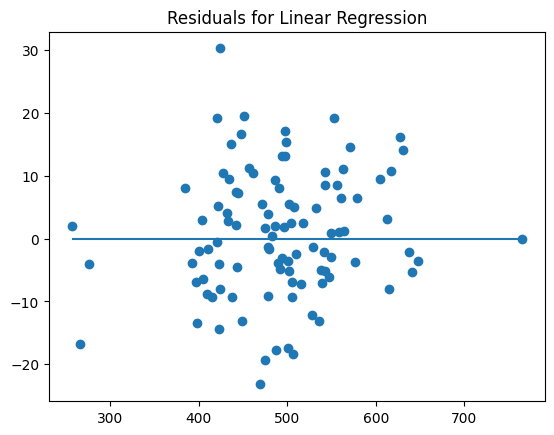

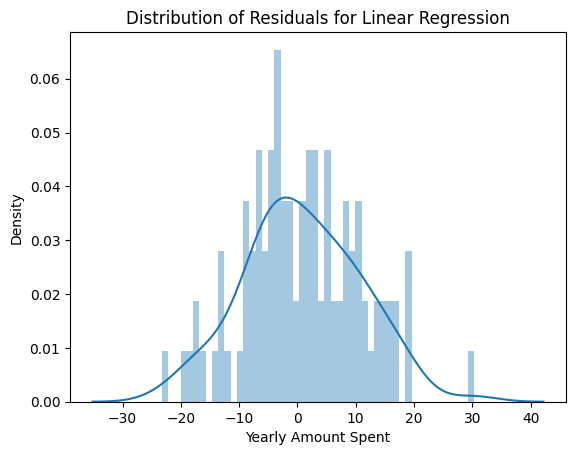

---------------------------------------------
Ridge Regression:
---------------------------------------------
Mean Absolute Error: 7.995247089930502
Mean Squared Error: 99.20843256846736
Root Mean Squared Error: 9.960342994519182
R2 Score: 0.9842126339217679
---------------------------------------------
Cross-validation scores: [0.98283459 0.98212908 0.98719805 0.98427575 0.98202045]
---------------------------------------------
                      Coefficient
Avg. Session Length        25.348
Time on App                38.240
Time on Website             0.313
Length of Membership       61.473
---------------------------------------------


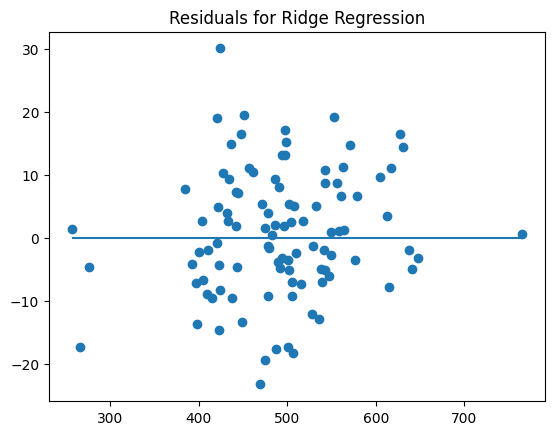

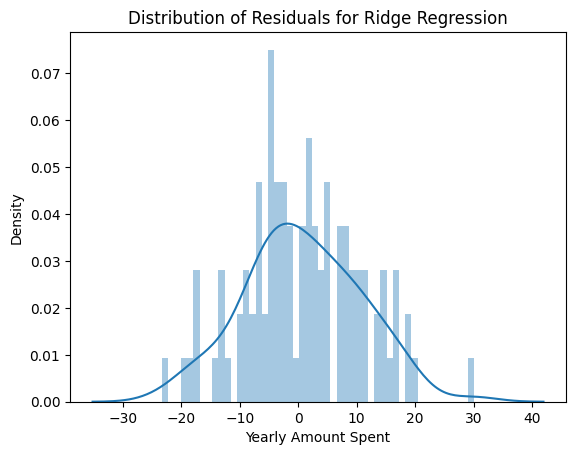

---------------------------------------------
Lasso Regression:
---------------------------------------------
Mean Absolute Error: 8.165383426285736
Mean Squared Error: 103.46131121423237
Root Mean Squared Error: 10.171593346876996
R2 Score: 0.9835358592733967
---------------------------------------------
Cross-validation scores: [0.98310911 0.98184379 0.98701317 0.98379349 0.98044527]
---------------------------------------------
                      Coefficient
Avg. Session Length        24.424
Time on App                37.342
Time on Website             0.000
Length of Membership       60.689
---------------------------------------------


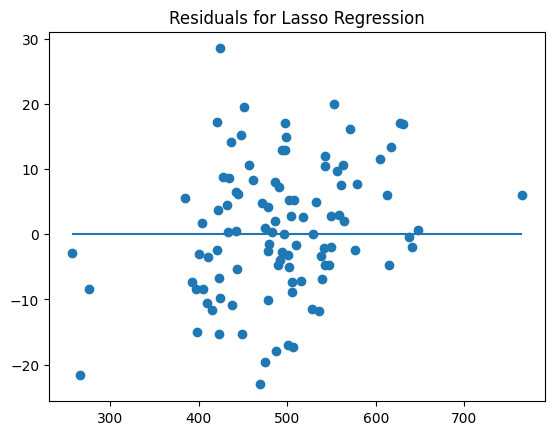

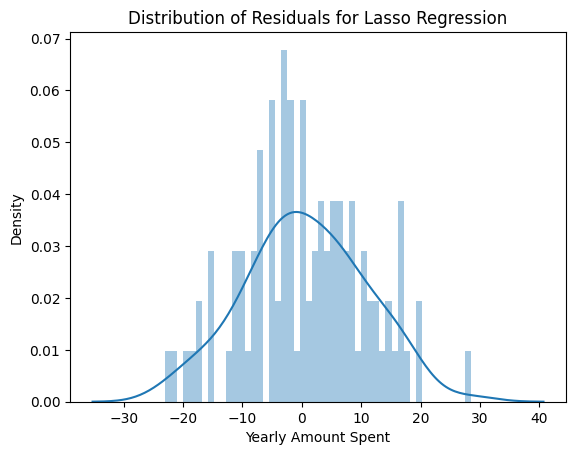

In [74]:
for result in result_list:
    name, model, predictions = result[0], result[1], result[2]
    print("---------------------------------------------")
    print(f"{name}:")
    print("---------------------------------------------")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    print('R2 Score:', metrics.r2_score(y_test, predictions))
    print("---------------------------------------------")
    scores = cross_val_score(model, X, y, cv=5)
    print('Cross-validation scores:', scores)
    print("---------------------------------------------")
    coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
    print(coeff_df)
    print("---------------------------------------------")
    plt.scatter(y_test, y_test - predictions)
    plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
    plt.title(f'Residuals for {name}')
    plt.show()

    sns.distplot((y_test - predictions), bins=50)
    plt.title(f'Distribution of Residuals for {name}')
    plt.show()

    

### LEARNING CURVE

name of the model : Linear Regression
[ 33 108 183 258 333]
[86.71017572 91.5036973  93.13938517 96.72771922 98.02708893]
[126.30347322 103.46936649 101.53872187 100.68502124 100.04475737]


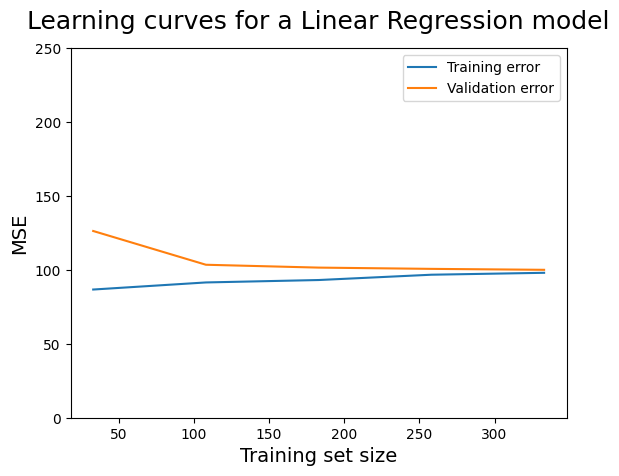

name of the model : Ridge Regression
[ 33 108 183 258 333]
[93.13278397 92.00515051 93.30820283 96.81364705 98.07801942]
[125.09621944 105.47350259 102.6637276  101.07568545 100.11574209]


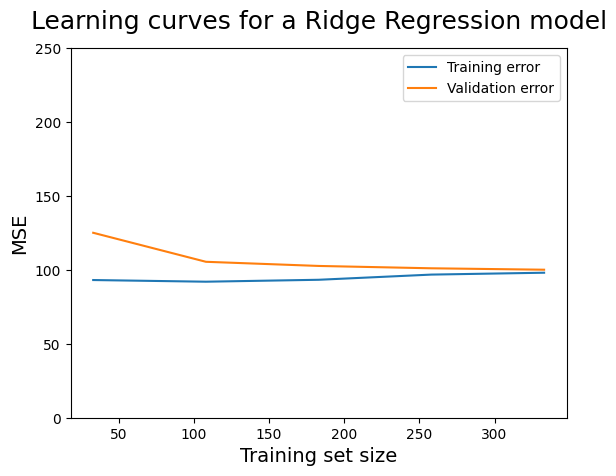

name of the model : Lasso Regression
[ 33 108 183 258 333]
[ 90.88631899  94.34070779  96.16338617 100.2477766  101.12048617]
[120.30793948 110.12590327 107.91266995 105.04526849 103.32370705]


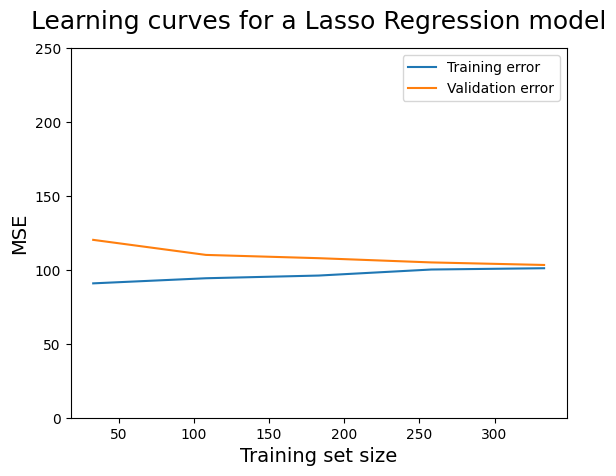

In [87]:
# Learning curve
for result in result_list:
    name, model = result[0], result[1]
    print(f'name of the model : {name}')
    train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=3, scoring = 'neg_mean_squared_error')
    print(train_sizes) 
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -test_scores.mean(axis = 1)

    print(train_scores_mean)
    print(validation_scores_mean)
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, validation_scores_mean, label='Validation error')
    plt.ylabel('MSE', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    plt.title('Learning curves for a ' + name + ' model', fontsize=18, y=1.03)
    plt.legend()
    plt.ylim(0,250)
    plt.show()

In [75]:
# Test the models with new data
new_data = np.array([[40, 10, 29, 5]])  # example new data

new_data_scaled = scaler.transform(new_data)

for result in result_list:
    name, model = result[0], result[1]
    prediction = model.predict(new_data_scaled)
    print(f"Prediction for {name} with new data: {prediction[0]}")

Prediction for Linear Regression with new data: 685.9369885834699
Prediction for Ridge Regression with new data: 685.5282609760617
Prediction for Lasso Regression with new data: 682.2848779661985


## FEATURE IMPORTANCE OR MODEL INTERPRETATION

                      Coefficient
Avg. Session Length        25.406
Time on App                38.336
Time on Website             0.314
Length of Membership       61.619


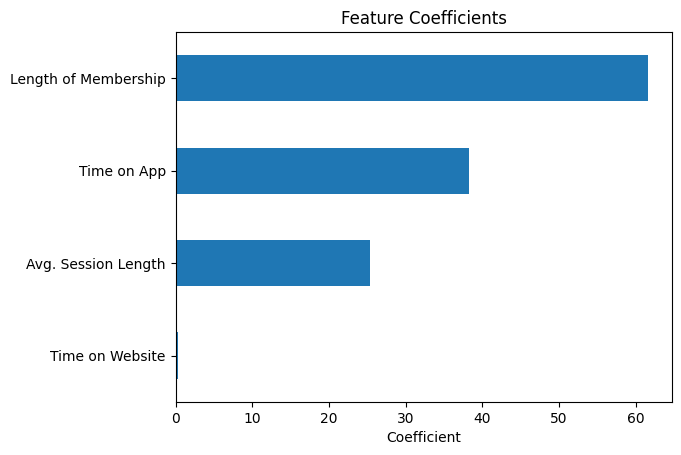

                      Coefficient
Avg. Session Length        25.348
Time on App                38.240
Time on Website             0.313
Length of Membership       61.473


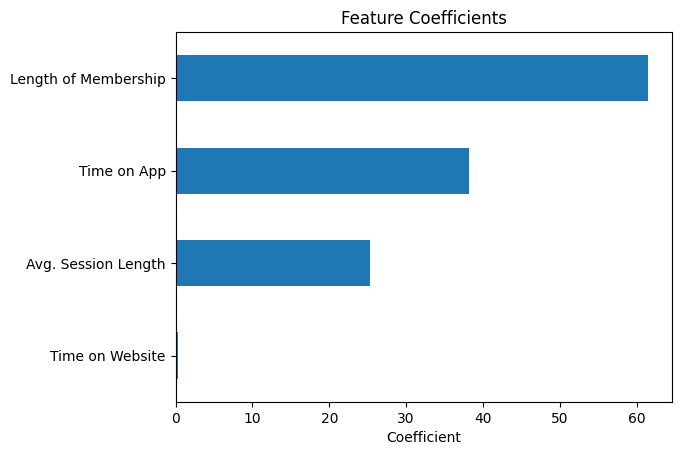

                      Coefficient
Avg. Session Length        24.424
Time on App                37.342
Time on Website             0.000
Length of Membership       60.689


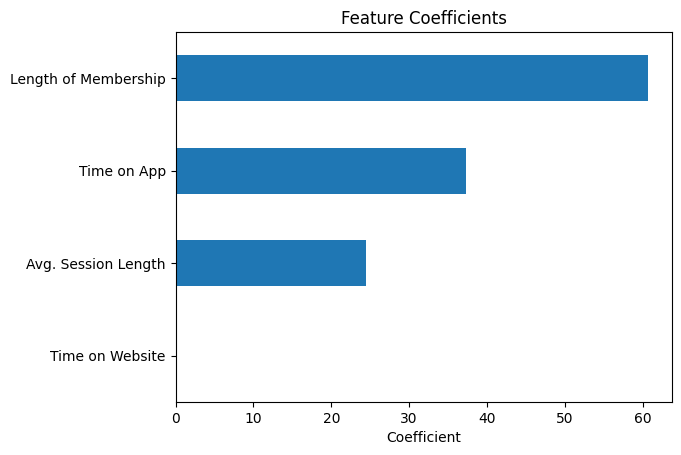

In [96]:
for result in result_list:
    name, model = result[0], result[1]
    coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

    # Output
    print(coeff_df)

    coeff_df.sort_values(by='Coefficient').plot(kind='barh', legend=False)
    plt.xlabel('Coefficient')
    plt.title('Feature Coefficients')
    plt.show()

If the coefficient for 'Time on App' is 3, it means that for each additional unit of time spent on the app, the yearly amount spent increases by 3 units, assuming all other factors remain constant.

Positive coefficients indicate that as the input variable increases, the output variable also increases. Negative coefficients indicate that as the input variable increases, the output variable decreases.

This interpretation assumes a linear relationship between the input and output variables, and it may not hold if this assumption is violated. 

For more complex models like Random Forests, the interpretation is not as straightforward because they are not based on the same assumptions as linear models. Instead, it is often used feature importance to understand the influence of each input variable.

## TRIED WITH DIFFERENT MODELS

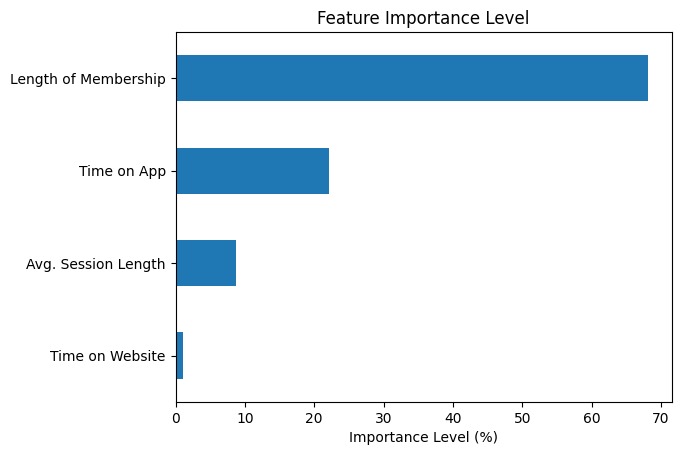

In [94]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

model = rf.fit(X, y)
importance_level = pd.DataFrame((model.feature_importances_*100),
                             index = X.columns,
                             columns=['Importance level']
                             )

importance_level.sort_values(by='Importance level').plot(kind='barh', legend=False)
plt.xlabel('Importance Level (%)')
plt.title('Feature Importance Level')
plt.show()

[25.61149536 38.51510053  0.42711121 61.27737207]

elasticNet_importance_level: 
                       Importance level
Avg. Session Length           2561.150
Time on App                   3851.510
Time on Website                 42.711
Length of Membership          6127.737


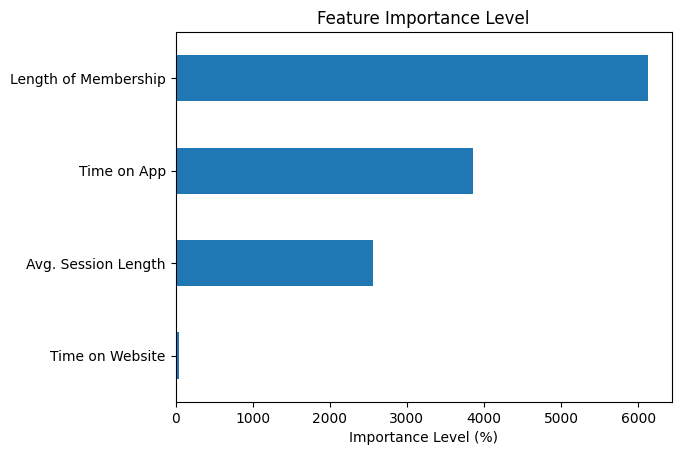

In [95]:
from sklearn.linear_model import ElasticNet

ElasticNet_Ridge = ElasticNet(alpha=0.01)
ElasticNet_Ridge.fit(X, y)

# coefficients of variables
print(ElasticNet_Ridge.coef_)

elasticNet_importance_level = pd.DataFrame((ElasticNet_Ridge.coef_*100),
                             # Importance Level
                             index = X.columns,
                             # Input variables
                             columns=['Importance level']
                             )
print('\nelasticNet_importance_level: \n',elasticNet_importance_level)

elasticNet_importance_level.sort_values(by='Importance level').plot(kind='barh', legend=False)
plt.xlabel('Importance Level (%)')
plt.title('Feature Importance Level')
plt.show()